# Stock Forecast Using Single Denoised Data

This example is going to demonstrate how to use time_seris_transform to denoise data prepare lag/lead features. In this exmple, there are four steps
1. prepare raw and denoise data
2. make lag/lead feature
3. Sklearn Model & Visualize Test

## Prepare raw data

In this example, we use Stock_Extractor to get an single stock data from yahoo finance.
Subsequently, we directly denoise the data using make_techinical_indicator funciton. This function is a wrapper which can take function object and transform the traget column.In time_series_transform.transform_core_api.util, there are different pre-made fucntion for feature engineering such as geometric moving average, wavelet transformation, or fast fourier transformation.

In [25]:
import pandas as pd
import seaborn as sns
import time_series_transform as tst
from time_series_transform.transform_core_api.util import wavelet_denoising

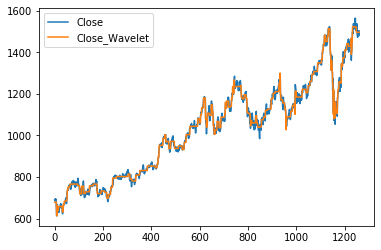

In [146]:
stock = tst.Stock_Extractor('googl','yahoo').get_stock_period('5y') # get period of stock
df = stock.make_technical_indicator("Close","Close_Wavelet",wavelet_denoising,wavelet='haar').dataFrame # denoise data
stock.plot(["Close","Close_Wavelet"])

## Make lag/lead features

After we prepared the data, we can use Pandas_Time_Series_Panel_Dataset to make lag or lead data as feature or target values for machine learning models. In this example, we only make 30-day lags data for Close data with Wavelet transformation, and only 1 step forward data as label.

In [148]:
panel_trans = tst.Pandas_Time_Series_Panel_Dataset(df)
panel_trans = panel_trans.make_slide_window('Date',30,['Close_Wavelet'])
panel_trans = panel_trans.make_lead_column('Date','Close',1)
df = panel_trans.df

In [149]:
df = df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Close_Wavelet', 'symbol'],axis =1).dropna()
df = df.sort_values('Date')
print(df.head())

         Date  Close_Wavelet_lag1  Close_Wavelet_lag2  Close_Wavelet_lag3  \
0  2015-08-12          678.338125          678.338125          678.338125   
1  2015-08-13          678.338125          678.338125          678.338125   
2  2015-08-14          678.338125          678.338125          678.338125   
3  2015-08-17          678.338125          678.338125          678.338125   
4  2015-08-18          678.338125          678.338125          678.338125   

   Close_Wavelet_lag4  Close_Wavelet_lag5  Close_Wavelet_lag6  \
0          678.338125          678.338125          678.338125   
1          678.338125          678.338125          678.338125   
2          678.338125          678.338125          613.123125   
3          678.338125          613.123125          613.123125   
4          613.123125          613.123125          661.683125   

   Close_Wavelet_lag7  Close_Wavelet_lag8  Close_Wavelet_lag9  ...  \
0          678.338125          613.123125          613.123125  ...   
1     

## Machine learning model & visualize test results

After we pre-process the data, we can use sklearn to predict the value. In this example, we use Random Forest with Random Search Tuner to prepare our model.

In [14]:
from sklearn.model_selection import TimeSeriesSplit,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [13]:
train = df[df.Date<'2020-07-01']
test = df[df.Date >= '2020-07-01']

In [69]:
rf = RandomForestRegressor(n_jobs =1,)
haparms = [{
    "n_estimators":np.arange(100,200,10,dtype=int),
    "min_samples_split":np.arange(2,40,1,dtype=int),
    "min_samples_leaf":np.arange(2,40,1,dtype=int),
}]

randomSearch = RandomizedSearchCV(
    rf,
    haparms,5,
    cv = TimeSeriesSplit(3),
    n_jobs =1
)

In [70]:
trainX= train.drop(['Date','Close_lead1'],axis = 1)
trainY = train.Close_lead1
randomSearch.fit(trainX,trainY)

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0...
       19, 20, 21, 22, 23, 24, 25

In [71]:
test= test.sort_values('Date')
testX= test.drop(['Date','Close_lead1'],axis = 1)
testY = test.Close_lead1
test_prd = randomSearch.predict(testX)
train_prd = randomSearch.predict(trainX)

In [72]:
compareFrame = pd.DataFrame({'train_prd':train_prd,'train_real':train.Close_lead1.tolist()},index = train.Date)
compareFrame_test = pd.DataFrame({'test_prd':test_prd,'test_real':test.Close_lead1.tolist()},index = test.Date)
compareFrame = compareFrame.append(compareFrame_test)
compareFrame['Date'] = compareFrame.index
compareFrame.index = list(range(1,len(compareFrame)+1))

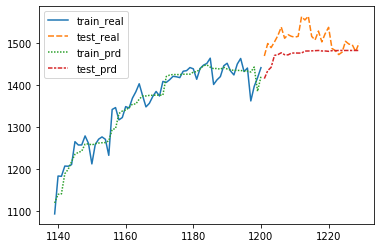

In [73]:
sns.lineplot(data= [
    compareFrame[compareFrame.Date >'2020-04-01'].train_real, 
    compareFrame[compareFrame.Date >='2020-07-01'].test_real,
    compareFrame[compareFrame.Date >'2020-04-01'].train_prd, 
    compareFrame[compareFrame.Date >='2020-07-01'].test_prd, 
])

# Stock Forecast Using Multiple Stock Features

This example is going to use a set of stocks to predict one stock. This example also implments different algorithms for feature engineering. Furthermore, this example will show how to implment functional object in Pandas_Time_Series_Panel_Dataset class.
There are three steps in this example
1. prepare stocks data through Portfolio_Extractor api and transform data
2. making lag/lead data and other feature engineering function using Pandas_Time_Series_Panel_Dataset
3. sklearn model and visualize test results

## Prepare stocks data and transformation

Portfolio_Extractor takes a list of stock ticks, and return an Portfolio objects. In this example, we prepare 5 year of data. Subsequently, we transform Close, Open, High, Low values using wavelet, fast fourier, and geometric moving average.

In [1]:
import time_series_transform as tst
from time_series_transform.transform_core_api.util import wavelet_denoising,rfft_transform,geometric_ma

In [2]:
port = tst.Portfolio_Extractor(['googl','aapl','fb'],'yahoo').get_portfolio_period('5y')

In [3]:
colList = ['Close','Open','High','Low']
denoiseCol = []
for col in colList:
    port.make_technical_indicator(col,f'{col}_wavelet',wavelet_denoising,wavelet='haar')
    port.make_technical_indicator(col,f'{col}_fft',rfft_transform,threshold=0.001)
    port.make_technical_indicator(col,f'{col}_gma20',geometric_ma,windowSize=20)
    port.make_technical_indicator(col,f'{col}_gma200',geometric_ma,windowSize=200)
    denoiseCol.extend([f'{col}_wavelet',f'{col}_fft',f'{col}_gma200',f'{col}_gma20'])

In [4]:
df = port.get_portfolio_dataFrame()
print(df.head())

         Date    Open    High     Low   Close   Volume  Dividends  \
0  2015-08-12  694.49  696.00  680.51  691.47  2924900        0.0   
1  2015-08-13  689.20  694.03  682.18  686.51  1817700        0.0   
2  2015-08-14  684.04  692.26  682.90  689.37  1379900        0.0   
3  2015-08-17  688.04  694.74  683.06  694.11  1234000        0.0   
4  2015-08-18  691.07  695.76  685.32  688.73  1385500        0.0   

   Stock Splits  Close_wavelet    Close_fft  ...  Open_gma200  High_wavelet  \
0             0     678.338125  1027.446516  ...          NaN       692.755   
1             0     678.338125  1027.446516  ...          NaN       692.755   
2             0     678.338125  1027.446516  ...          NaN       692.755   
3             0     678.338125  1027.446516  ...          NaN       692.755   
4             0     678.338125  1027.446516  ...          NaN       692.755   

      High_fft  High_gma20  High_gma200  Low_wavelet      Low_fft  Low_gma20  \
0  1036.619071         NaN    

## Lag/lead data and other feature engineering

Here, we create an moving standard deviation feature and make 20-day-lag with denoised data from previous step. In order to create the proper feature, we have to be aware of its category. That means that we have to group by each stocks. After making new feature, we can create lag data and expand it by its category.

To manipulate the data using transform_dataFrame function, the first argument of the function must be the data array/list, and the output must be numpy array or list.

In [5]:
df = df.drop(['Volume','Dividends','Stock Splits'],axis =1)
panel_transform = tst.Pandas_Time_Series_Panel_Dataset(df)

In [9]:
import pandas as pd
def moving_std (arr,windowSize):
    res = pd.Series(arr).rolling(windowSize).std()
    return res
panel_transform = panel_transform.transform_dataFrame('Close','Close_std','Date','symbol',moving_std,windowSize = 10)

In [10]:
panel_transform = panel_transform.make_slide_window(
    indexCol = 'Date',
    windowSize = 20,
    colList = denoiseCol+['Close_std'],
    groupby = 'symbol')
panel_transform = panel_transform.expand_dataFrame_by_category('Date','symbol')

In [11]:
print(panel_transform.df.head())

         Date  Open_aapl  High_aapl  Low_aapl  Close_aapl  Close_wavelet_aapl  \
0  2015-08-12     103.99     106.66    101.31      106.49          105.099219   
1  2015-08-13     107.23     107.57    105.85      106.41          105.099219   
2  2015-08-14     105.64     107.48    105.36      107.16          105.099219   
3  2015-08-17     107.23     108.72    106.74      108.27          105.099219   
4  2015-08-18     107.59     108.53    107.21      107.66          105.099219   

   Close_fft_aapl  Close_gma20_aapl  Close_gma200_aapl  Open_wavelet_aapl  \
0       173.68827               NaN                NaN         107.643125   
1       173.68827               NaN                NaN         107.643125   
2       173.68827               NaN                NaN         107.643125   
3       173.68827               NaN                NaN         107.643125   
4       173.68827               NaN                NaN         107.643125   

   ...  Close_std_lag11_googl  Close_std_lag12_goo

In [12]:
panel_transform = panel_transform.make_lead_column('Date','Close_googl',1)
df = panel_transform.df
df = df.dropna()

In [23]:
from sklearn.model_selection import TimeSeriesSplit,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns

In [19]:
train = df[df.Date<'2020-07-01']
test = df[df.Date >= '2020-07-01']

In [20]:
rf = RandomForestRegressor(n_jobs =1)
haparms = [{
    "n_estimators":np.arange(100,200,10,dtype=int),
    "min_samples_split":np.arange(2,40,1,dtype=int),
    "min_samples_leaf":np.arange(2,40,1,dtype=int),
}]

randomSearch = RandomizedSearchCV(
    rf,
    haparms,10,
    cv = TimeSeriesSplit(3),
    n_jobs =1
)

In [21]:
train = train.sort_values('Date')
trainX= train.drop(['Date','Close_googl_lead1'],axis = 1)
trainY = train.Close_googl_lead1
randomSearch.fit(trainX,trainY)
train_prd = randomSearch.predict(trainX)

In [22]:
test= test.sort_values('Date')
testX= test.drop(['Date','Close_googl_lead1'],axis = 1)
testY = test.Close_googl_lead1
test_prd = randomSearch.predict(testX)

In [24]:
compareFrame = pd.DataFrame({'train_prd':train_prd,'train_real':train.Close_googl_lead1.tolist()},index = train.Date)
compareFrame_test = pd.DataFrame({'test_prd':test_prd,'test_real':test.Close_googl_lead1.tolist()},index = test.Date)
compareFrame = compareFrame.append(compareFrame_test)
compareFrame['Date'] = compareFrame.index
compareFrame.index = list(range(1,len(compareFrame)+1))

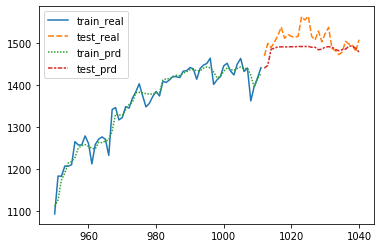

In [25]:
sns.lineplot(data= [
    compareFrame[compareFrame.Date >'2020-04-01'].train_real, 
    compareFrame[compareFrame.Date >='2020-07-01'].test_real,
    compareFrame[compareFrame.Date >'2020-04-01'].train_prd, 
    compareFrame[compareFrame.Date >='2020-07-01'].test_prd, 
])